# Radon transform

https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html

## The forward transform
As our original image, we will use the Shepp-Logan phantom. When calculating the Radon transform, we need to decide how many projection angles we wish to use. As a rule of thumb, the number of projections should be about the same as the number of pixels there are across the object (to see why this is so, consider how many unknown pixel values must be determined in the reconstruction process and compare this to the number of measurements provided by the projections), and we follow that rule here. Below is the original image and its Radon transform, often known as its sinogram:

## Прямое преобразование
В качестве исходного изображения мы будем использовать фантом Шеппа-Логана. При вычислении преобразования Радона нам нужно решить, сколько углов проекции мы хотим использовать. Как правило, количество проекций должно быть примерно равно количеству пикселей на объекте (чтобы понять, почему это так, рассмотрим, сколько неизвестных значений пикселей должно быть определено в процессе реконструкции, и сравним это с количеством измерений, предоставленных проекциями), и мы следуем этому правилу здесь. Ниже представлено исходное изображение и его преобразование Радона, часто известное как его синограмма:

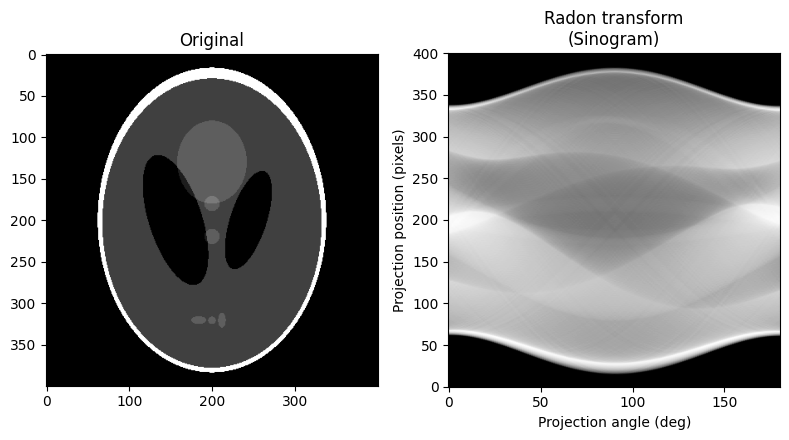

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon

image = shepp_logan_phantom()
#image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

projections = 180
theta = np.linspace(0.0, 180.0, projections, endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

## Back Projection (FBP)
The mathematical foundation of the back projection is the Fourier slice theorem [2]. It uses Fourier transform of the projection and interpolation in Fourier space to obtain the 2D Fourier transform of the image, which is then inverted to form the reconstructed image. 

## Обратная проекция (FBP)
Математической основой  обратной проекции является теорема о срезе Фурье [2]. Она использует преобразование Фурье проекции и интерполяцию в пространстве Фурье для получения двумерного преобразования Фурье изображения, из которого с помощью обратного преобразования Фурье реконструируется изображение. 

Чтобы сравнить результат реконструкции и исходное изображение количествено надо учитывать, что исходный фантом задан значениями интенсивности в диапазоне \[0,1\], а результат реконструкции может находиться в другом диапазоне.

Дополнительно оценим время расчета.

FBP rms reconstruction error: 0.544
Calculated time: 0.845 s


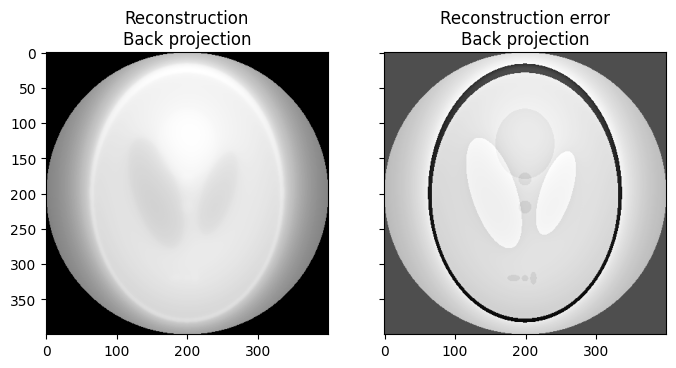

In [2]:
import time 

start=time.time()
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name=None)
end=time.time()-start

reconstruction_fbp /= np.max(reconstruction_fbp)
error = reconstruction_fbp - image

print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')
print(f'Calculated time: {end:.3g} s')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nBack projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nBack projection")
ax2.imshow(error, cmap=plt.cm.Greys_r) #plt.cm.Greys_r, **imkwargs)
plt.show()

Сравните Фурье спектр исходного и восстановленного изображений, 2D и одномерный (например взяв среднюю строку).

Функция, производящее преобразование Фурье и сдвиг спектра:
```python
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)
```
https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

Сравнивать уместнее спектры мощности, для чего вычислить модуль комплексного числа.

Из-за большого диапазона значений можно дополнительно логарифмировать значения.

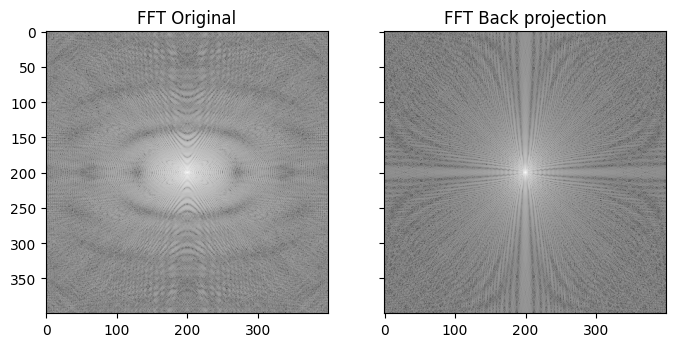

In [3]:
def calculate_2dft(input):
    ft = np.fft.fft2(input)
    ft = np.fft.ifftshift(ft)
    return np.log(np.abs(ft))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("FFT Original")
ax1.imshow(calculate_2dft(image), cmap=plt.cm.Greys_r)
ax2.set_title("FFT Back projection")
ax2.imshow(calculate_2dft(reconstruction_fbp), cmap=plt.cm.Greys_r)
plt.show()

Построим горизонтальную и вертикальную строки, проходящие через центр спектра.
Дополнительно введем смещение по горизонтальной оси, чтобы корректно отображались частоты.

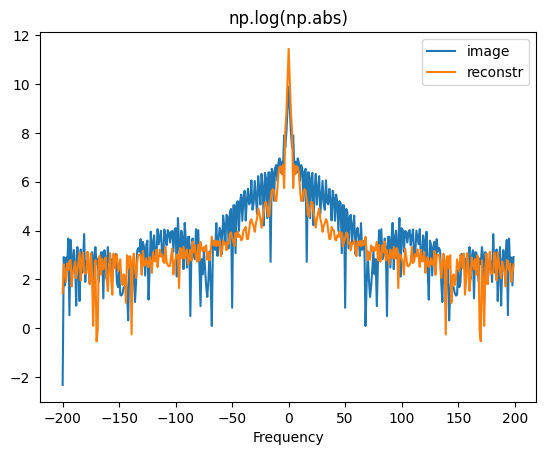

In [4]:
middle = np.shape(image)[0]//2

f_scale = np.arange(-middle, np.shape(image)[0] - middle)

plt.plot(f_scale, calculate_2dft(image)[middle,:], label='image') # :,middle
plt.plot(f_scale, calculate_2dft(reconstruction_fbp)[middle,:], label='reconstr') # :,middle
plt.title("np.log(np.abs)")
plt.legend()
plt.xlabel("Frequency")
#plt.yscale('log')
plt.show()

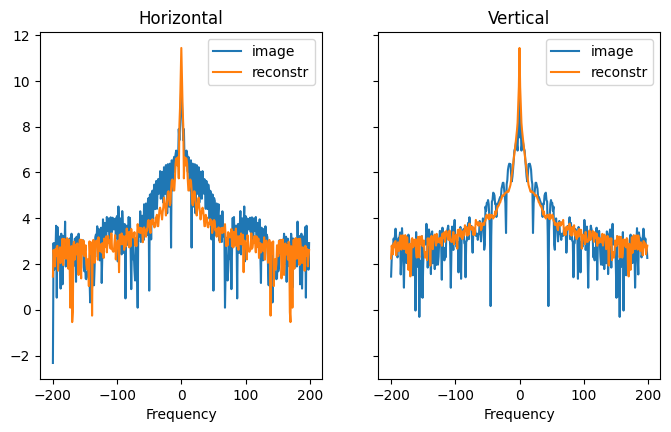

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Horizontal")
ax1.plot(f_scale, calculate_2dft(image)[middle,:], label='image')
ax1.plot(f_scale, calculate_2dft(reconstruction_fbp)[middle,:], label='reconstr')
ax1.legend()
ax1.set_xlabel("Frequency")
ax2.set_title("Vertical")
ax2.plot(f_scale, calculate_2dft(image)[:,middle], label='image')
ax2.plot(f_scale, calculate_2dft(reconstruction_fbp)[:,middle], label='reconstr')
ax2.legend()
ax2.set_xlabel("Frequency")
plt.show()

### Вопрос:
У какого образца выше НЧ, у какого ВЧ?
Как это связано с отличиями в двух изображений - исходном и восстановленном?

## Reconstruction with the Filtered Back Projection (FBP)
The mathematical foundation of the filtered back projection is the Fourier slice theorem [2]. It uses Fourier transform of the projection and interpolation in Fourier space to obtain the 2D Fourier transform of the image, which is then inverted to form the reconstructed image. The filtered back projection is among the fastest methods of performing the inverse Radon transform. The only tunable parameter for the FBP is the filter, which is applied to the Fourier transformed projections. It may be used to suppress high frequency noise in the reconstruction. skimage provides the filters ‘ramp’, ‘shepp-logan’, ‘cosine’, ‘hamming’, and ‘hann’:

## Реконструкция с помощью отфильтрованной обратной проекции (FBP)
Математической основой отфильтрованной обратной проекции является теорема о срезе Фурье [2]. Она использует преобразование Фурье проекции и интерполяцию в пространстве Фурье для получения двумерного преобразования Фурье изображения, которое затем инвертируется для формирования реконструированного изображения. Отфильтрованная обратная проекция является одним из самых быстрых методов выполнения обратного преобразования Радона. Единственным настраиваемым параметром для FBP является фильтр, который применяется к преобразованным Фурье проекциям. Его можно использовать для снижения вклада низких частот, а также подавления высокочастотного шума при реконструкции. Skimage предоставляет фильтры ‘ramp’, ‘shepp-logan’, ‘cosine’, ‘hamming’, and ‘hann’:

Рассмотрим применяемые в томографии частотные фильтры. Как по-вашему они повлияют на выходное изображение?

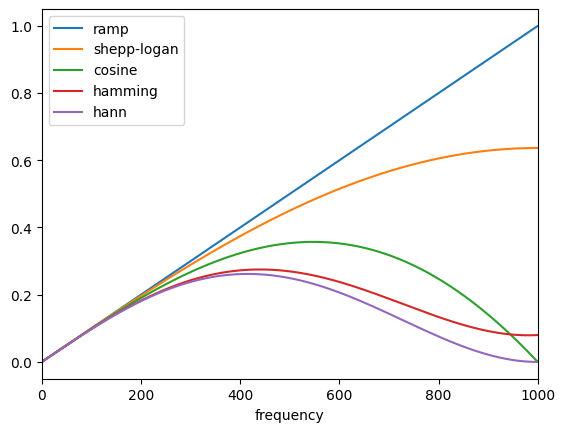

In [6]:
import matplotlib.pyplot as plt
from skimage.transform.radon_transform import _get_fourier_filter

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

xmax = 1000

for f in filters:
    response = _get_fourier_filter(2*xmax, f)
    plt.plot(response, label=f)

plt.xlim([0, xmax])
plt.xlabel('frequency')
plt.legend()
plt.show()

Applying the inverse radon transformation with the ‘ramp’ filter, we get:

FBP rms reconstruction error: 0.0472
Calculated time: 0.815 s


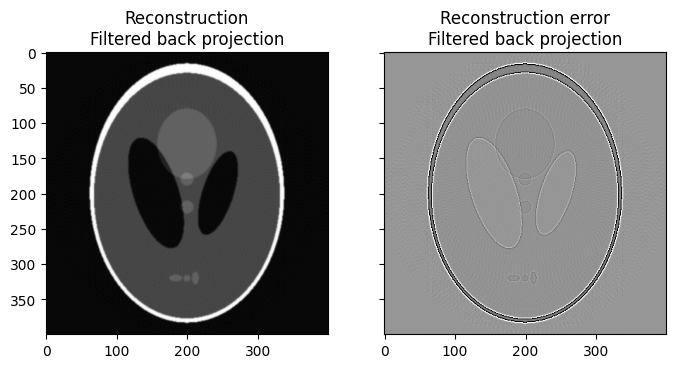

In [7]:
from skimage.transform import iradon

import time 

start=time.time()
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann')
end=time.time()-start
reconstruction_fbp/= np.max(reconstruction_fbp)
error = reconstruction_fbp - image

print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')
print(f'Calculated time: {end:.3g} s')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

### Задание:
Сравните частотные спектры исходного изображения и изображений, полученных с помощью фильтрованной обратной проеции.

Какое видно отличие в сравнении со случаем без применения фильтров?

### Дополнение

Для преобразования произвольного рисунка в массив могут потребоваться следующие функции:

Использование функции numpy.asarray() или numpy.array():
```python
from PIL import Image
import numpy as np

# load the image and convert into numpy array
img = Image.open('filename')

# convert PIL images into NumPy arrays
numpydata = np.asarray(img)
```
или
```python
np_img = np.array(img)
```

Получение обратно изображения из преобразованного массива Numpy:
```python
pilImage = Image.fromarray(numpydata)
```

How to Convert images to NumPy array? https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/

Convert a black and white image to array of numbers? https://stackoverflow.com/questions/51205502/convert-a-black-and-white-image-to-array-of-numbers

Images are numpy arrays https://scikit-image.org/skimage-tutorials/lectures/00_images_are_arrays.html

#### 2D FFT

https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft2.html

https://scipython.com/book/chapter-6-numpy/examples/blurring-an-image-with-a-two-dimensional-fft/

https://github.com/NakerTheFirst/Fourier-transforms

## Сравним скорость выполнения преобразований

Simple way to measure cell execution time

https://stackoverflow.com/questions/32565829/simple-way-to-measure-cell-execution-time-in-ipython-notebook

%%time measures how long it took something to run. It’s better for reporting on long-running operations than for doing low-level optimization.

%%timeit is a benchmarking tool that runs statements over and over to give the average runtime for some statements, as well as the standard deviation. Because of the way in which the statements are repeatedly executed, the variables created in %%timeit cells are not available in other cells.

```python

%%time

def foo():
    continue

foo()

```

In [8]:
%%timeit

_ = iradon(sinogram, theta=theta, filter_name=None)

781 ms ± 51.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%time

_ = iradon(sinogram, theta=theta, filter_name=None)

CPU times: total: 750 ms
Wall time: 755 ms


In [10]:
%%time

_ = iradon(sinogram, theta=theta, filter_name='hann')

CPU times: total: 781 ms
Wall time: 810 ms


In [11]:
%%time

_ = iradon(sinogram, theta=theta, filter_name='ramp')

CPU times: total: 750 ms
Wall time: 770 ms


Или можно самостоятельно организовать цикл с нужным числом повторений:

In [12]:
%%time
def bench(num):
    for i in range(num):
        iradon(sinogram, theta=theta, filter_name=None)

bench(10)
#_ = iradon(sinogram, theta=theta, filter_name=None)


CPU times: total: 7.7 s
Wall time: 7.7 s


In [13]:
%%time
def bench(num):
    for i in range(num):
        iradon(sinogram, theta=theta, filter_name='hann')

bench(10)
#_ = iradon(sinogram, theta=theta, filter_name=None)


CPU times: total: 7.56 s
Wall time: 7.61 s
